In [312]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [313]:
import sys

sys.path.append("../..")

In [314]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_mas.common.orthotopes.base import batch_create_hypercube
from torch_mas.common.models.linear_models import batch_predict_linear_regression

In [315]:
import matplotlib.patches as patches
from scipy.interpolate import griddata

def plot_hypercubes(ax, hypercubes: torch.Tensor, color="C0", alpha=0.4):
    for h in hypercubes:
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = patches.Rectangle(low, side_lengths[0], side_lengths[1], facecolor=color, alpha=alpha)
        ax.add_patch(patch)

def plot_as_heatmap(ax, x, y, z, n_points=1000, cmap="viridis", norm=None, interpolation="linear"):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm)
    return pcm

## Learning

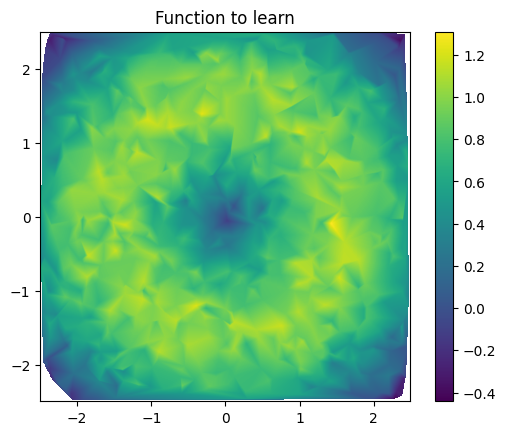

In [316]:
from torch.utils.data import TensorDataset, DataLoader

device = "cpu"

num_samples = 1000
test_size = 1000
num_features = 2
noise_level = 0.1
X = (torch.rand(num_samples, num_features)-0.5)*5
y = (torch.sin(torch.sqrt(X[:, 0]**2 + X[:, 1]**2)) + torch.randn(X.size(0))*noise_level).unsqueeze(-1)
X_test = (torch.rand(num_samples, num_features)-0.5)*5
y_test = (torch.sin(torch.sqrt(X_test[:, 0]**2 + X_test[:, 1]**2))).unsqueeze(-1)
train_dataset = TensorDataset(X, y)

X.shape, y.shape

fig = plt.gcf()
ax = plt.gca()
# pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_test)
pcm = plot_as_heatmap(ax, X[:, 0], X[:, 1], y)
ax.set_title("Function to learn")
fig.colorbar(pcm)

In [320]:
from torch_mas.batch.activation_function import SmoothActivation
from torch_mas.batch.internal_model import LinearModule
from torch_mas.batch.trainer import GBELMATrainer

n_agents_ini = 10
input_dim = 2
output_dim = 1
lr = 1e-2
limit_probability = 0.3

# random agents initialization
side_lengths = torch.ones(n_agents_ini)*0.3
centers = torch.rand((n_agents_ini, 2))*4-2

activation = SmoothActivation(
    input_dim, 
    output_dim, 
    limit_value=0.3
)
internal_model = LinearModule(
    input_dim, 
    output_dim
)
model = GBELMATrainer(
    activation, 
    internal_model,
    n_agents_ini=n_agents_ini,
    R=side_lengths,
    lr=1e-2,
    n_epochs=40,
    batch_size=64
)

model.fit(train_dataset)

torch.Size([1000, 1])
torch.Size([1000, 1]) torch.Size([1000, 2])


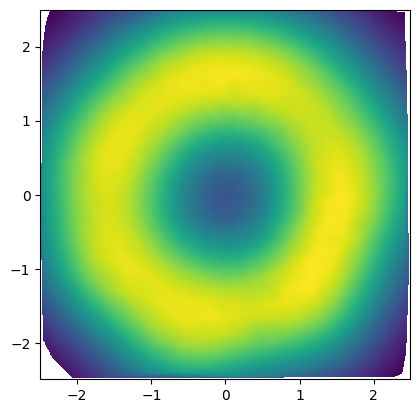

In [321]:
y = model.predict(X).detach()
print(y.shape)
print(y.shape, X.shape)
ax = plt.gca()
plot_as_heatmap(ax, X[:, 0], X[:, 1], y)